In [1]:
import h5py as h5
import numpy as np

DATA_DIR = 'data'

def normalize(images):
    images = np.array(images, np.float64)
    images -= np.min(images)
    images /= np.max(images)
    return images

def read_mnc(filename):
    with h5.File(filename, 'r') as f:
        return normalize(f['minc-2.0/image/0/image'])

In [2]:
import os

PATH_TPL = '{:02d}_{}.mnc'

def mr_path(index):
    return os.path.join(DATA_DIR, PATH_TPL.format(index, 'mr'))

def us_path(index):
    return os.path.join(DATA_DIR, PATH_TPL.format(index, 'us'))

In [9]:
mr_images = read_mnc(mr_path(1))
us_images = read_mnc(us_path(1))

np.shape(mr_images), np.shape(us_images)

((378, 466, 394), (378, 466, 394))

In [3]:
import skimage.color as color
import matplotlib.pyplot as plt

def show(mr_image, us_image):
    image = color.gray2rgb(mr_image)
    shape = np.shape(mr_image)
    zeros = np.zeros((shape[0], shape[1]))
    masks = np.dstack([us_image, zeros, zeros])
    
    plt.imshow(image + masks)
    plt.show()

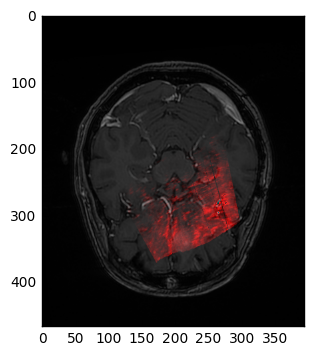

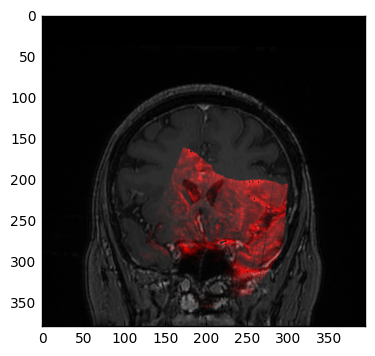

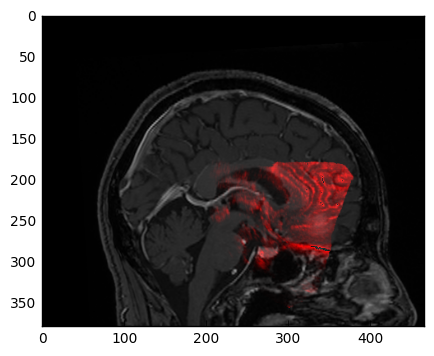

In [26]:
show(mr_images[120], us_images[120])
show(np.flipud(mr_images[:, 300, :]),
     np.flipud(us_images[:, 300, :]))
show(np.flipud(mr_images[:, :, 200]),
     np.flipud(us_images[:, :, 200]))

In [4]:
import sklearn.feature_extraction as fe

PATCH_THRESHOLD = 30
PATCH_HEIGHT = 7
PATCH_WIDTH = 7

def extract_patches(mr_image, us_image):
    mr_p = fe.image.extract_patches_2d(mr_image, (PATCH_HEIGHT, PATCH_WIDTH))
    us_p = fe.image.extract_patches_2d(us_image, (PATCH_HEIGHT, PATCH_WIDTH))
    
    return [(mr_p[i], us_p[i]) for i in range(len(mr_p)) if np.sum(us_p[i]) > PATCH_THRESHOLD]

In [5]:
import tensorflow as tf

def create_example(mr_patch, us_patch):
    return tf.train.Example(features=tf.train.Features(feature={
        'us_patch': tf.train.Feature(bytes_list=tf.train.BytesList(value=[mr_patch.tostring()])),
        'mr_patch': tf.train.Feature(bytes_list=tf.train.BytesList(value=[us_patch.tostring()])),
    }))

def write_tfrecord(filename, index):
    with tf.python_io.TFRecordWriter(filename) as writer:
        mr_images = read_mnc(mr_path(index))
        us_images = read_mnc(us_path(index))
        
        z, y, x = np.shape(us_images)
        
        for i in range(x):
            for patch in extract_patches(mr_images[:, :, i], us_images[:, :, i]):
                writer.write(create_example(patch[0], patch[1]).SerializeToString())
        print('-> wrote patches in x direction')
        for i in range(y):
            for patch in extract_patches(mr_images[:, i, :], us_images[:, i, :]):
                writer.write(create_example(patch[0], patch[1]).SerializeToString())
        print('-> wrote patches in y direction')
        for i in range(z):
            for patch in extract_patches(mr_images[i], us_images[i]):
                writer.write(create_example(patch[0], patch[1]).SerializeToString())
        print('-> wrote patches in z direction')

In [6]:
for i in range(1, 15):
    print('started record {}'.format(i))
    write_tfrecord('{:02}.tfrecord'.format(i), i)
    print('completed record {}'.format(i))
    print()

started record 1
-> wrote patches in x direction
-> wrote patches in y direction
-> wrote patches in z direction
completed record 1

started record 2
-> wrote patches in x direction
-> wrote patches in y direction
-> wrote patches in z direction
completed record 2

started record 3
-> wrote patches in x direction
-> wrote patches in y direction
-> wrote patches in z direction
completed record 3

started record 4
-> wrote patches in x direction
-> wrote patches in y direction
-> wrote patches in z direction
completed record 4

started record 5
-> wrote patches in x direction
-> wrote patches in y direction
-> wrote patches in z direction
completed record 5

started record 6
-> wrote patches in x direction
-> wrote patches in y direction
-> wrote patches in z direction
completed record 6

started record 7
-> wrote patches in x direction
-> wrote patches in y direction
-> wrote patches in z direction
completed record 7

started record 8
-> wrote patches in x direction
-> wrote patches in 